# RL Open Source Fest 2021 Pre-Screening Exercise

**Applicant:** Wilson Cheung

*Sources*:
[Simulating Content Personalization with Contextual Bandits](https://vowpalwabbit.org/tutorials/cb_simulation.html) and 
[Exploration Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms#changing-action-set-or-featurized-actions)

In the first [Contextual Bandits Reinforcement Learning](https://vowpalwabbit.org/tutorials/contextual_bandits.html) tutorial, we learned about this approach to reinforcement learning with Vowpal Wabbit and contextual bandit algorithms. In this tutorial, we simulate a content personalization scenario with Vowpal Wabbit using contextual bandits to make choices between actions in a given context. The goal is to maximize user engagement as quantified by measuring the expected reward — click-through rate (CTR).

In a contextual bandit setting, a data point has four components:

- Context
- Action
- Probability of choosing the action
- Reward/cost for the chosen action

We need to generate a context in our simulator to get an action/decision for the given context, and to simulate generating a reward. The goal of the simulator is to maximize reward (CTR) — or minimize loss (-CTR).

The **context** is therefore (user, time_of_day):

- We have two website visitors: “Tom” and “Anna.”
- Tom and Anna visit the website in the morning or the afternoon.

We have the option of recommending a variety of articles to Tom and Anna. Therefore, the **actions** are the different choices of articles: “politics”, “sports”, “music”, “food”, “finance”, “health”, or “cheese.”

The **reward** is whether they click on the article or not: “click” or “no click.”

## Getting started
Import the following packages to build this simulation in Python:

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

## Simulating reward for Vowpal Wabbit
In the real world, we must learn Tom and Anna’s preferences for articles as we observe their interactions. Since this is a simulation, we must define Tom and Anna’s preference profile. 

The reward that we provide to the learner follows this preference profile. We hope to see if the learner can make better and better decisions as we see more samples, which in turn means we are maximizing the reward.

To accomplish this, we need to modify the reward function in a few different ways and see if the contextual bandit learner picks up the changes. Then, we compare the CTR with and without learning.

Vowpal Wabbit optimizes to minimize cost, which is negative of reward. 

Therefore, **we always pass negative of reward as cost to Vowpal Wabbit**.

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes politics in the morning and music in the afternoon. Anna likes sports in the morning and politics in the afternoon. It looks dense, but we are simulating a hypothetical world in the format of the feedback the learner understands — cost.

If the learner recommends an article that aligns with the reward function, we give a positive reward. In our simulation, this is a click:

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

## Understanding Vowpal Wabbit format
There are steps we need to take to set up our input in a format Vowpal Wabbit understands. 

This function handles converting from our context as a dictionary, list of articles, and the cost if there is one into the text format it understands:

In [4]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

To make sense of this format, we go through an example. In this example, the time of day is morning, and the user is Tom. There are four possible articles. 

In Vowpal Wabbit format, there is one line that starts with shared-the shared context-followed by four lines each corresponding to an article:

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


## Getting a decision from Vowpal Wabbit
When we call Vowpal Wabbit, the output is a probability mass function (PMF). Vowpal Wabbit provides a list of probabilities over the set of actions because we are incorporating exploration into our strategy. This exploration means that the probability at a given index in the list corresponds to the likelihood of picking that specific action. 

To arrive at a decision/action, we must sample from this list.

For example, given the list **[0.7, 0.1, 0.1, 0.1]**, we would choose the first item with a 70% chance. The command `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

We have all the information we need to choose an action for a specific user and context. Use Vowpal Wabbit to achieve this with the following steps:

1. Convert the context and actions into the text format needed.
2. Pass this example to Vowpal Wabbit and get the PMF output.
3. Sample this PMF to get the article to show.
4. Return the chosen article and the probability of choosing it. 

**Note:** We need the probability when we learn from this example.

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Reinforcement learning simulation
Now that we have done all of the setup work and we know how to interface with Vowpal Wabbit let’s simulate the world of Tom and Anna. The scenario is as follows: Tom and Anna go to a website and are shown an article. Remember that the reward function allows us to define the real-world reaction to the content that Vowpal Wabbit recommends.

We choose between Tom and Anna uniformly at random and choose the time of day they visit the site uniformly at random. Think of this as flipping a coin to choose between Tom and Anna and flipping the coin again to choose the time of day.

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

## Instantiate learner
We instantiate a contextual bandit learner in Vowpal Wabbit and then simulate Tom and Anna’s website visits num_iterations number of times. With each visit, we do the following:

1.  Decide between Tom and Anna
2.  Decide the time of day
3.  Pass context (i.e., user, time of day) to the learner to get action (i.e., article recommendation, and the probability of choosing action).
4.  Receive reward (i.e., see if the user clicked or not). Remember that cost is just a negative reward.
5.  Format context, action, probability, reward in Vowpal Wabbit format
6.  Learn from the example

**Note:** Vowpal Wabbit reduces a contextual bandit problem to a cost-sensitive multiclass classification problem.

This reduction is the same for every one of our simulations, so we define the process in the run_simulation function. We have to supply the cost function to simulate how the real world works:

In [9]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

**Note:** `finish_example` is important as it updates statistics and frees used memory.

We want to be able to visualize what is occurring, so we are going to plot the click-through rate over each iteration of the simulation. The CTR is higher if Vowpal Wabbit is showing actions that get rewards. Use this utility function to make showing the plot easier:

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## First scenario
First, we use the first reward function `get_cost` and assume that Tom and Anna do not change their preferences over time to see what happens to user engagement as we learn. Then, we see what happens when there is no learning. We use the no learning case as our baseline comparison.

### With learning

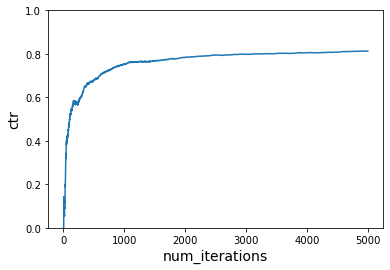

In [11]:
# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

### Interactions
You’ll notice that we include `-q UA` in the arguments we supply to Vowpal Wabbit. This step tells Vowpal Wabbit to create additional features, which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. Doing so allows us to learn the interaction between when specific actions are good at certain times of days and for specific users.

If we didn’t include `-q UA`, the learning would not work. We can see that in the following action:

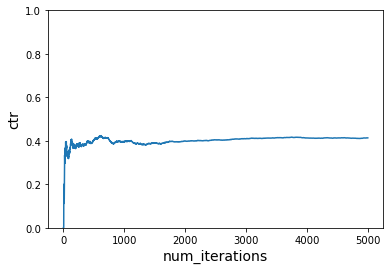

In [12]:
# Instantiate learner in VW but without -q
random.seed(1)
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

### Without learning
Let’s do the same thing again, but with `-q`. This step shows the effect if we don’t learn from what happens. The CTR never improves, and we hover around 0.2.

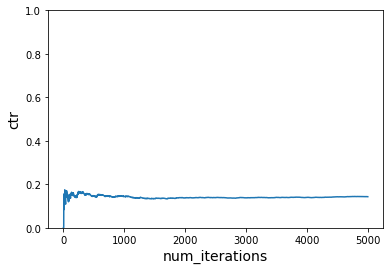

In [13]:
# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

## Second scenario
People’s preferences change over time in the real world. To account for this in the simulation, we incorporate two different cost functions and swap over to the second one halfway through.

The following table represents the new reward function `get_cost_new1`:

| Tom | `get_cost` | `get_cost_new1` |
| --- | --- | --- |
| Morning | Politics | Politics |
| Afternoon | Music | Sports |


| Anna | `get_cost` | `get_cost_new1` |
| --- | --- | --- |
| Morning | Sports | Sports |
| Afternoon | Politics | Sports |

This reward function is still working with the previous learner actions:

In [14]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

To make it easy to show the effect of the cost function changing, we modify the `run_simulation` function. It is a little less readable, but it supports accepting a list of cost functions, and it operates over each cost function in turn.

This change is perfect for our scenario:

In [15]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### With learning
Now, we switch to the second reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of web users, but it is still working with the same action space as before. We should see the learner pick up these changes and optimize the new preferences.

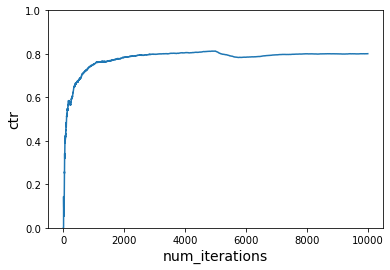

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

**Note:** The initial spike in CTR depends on the rewards received for the first few examples. When you run on your own, you may see something different initially because our simulator is designed to have randomness.

### Without learning
We repeat this step without learning to demonstrate the effect:

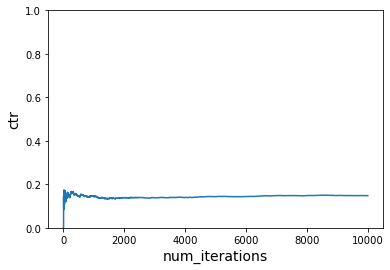

In [17]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Python / Data Science Exercise

The goals of this exercise is to modify the second scenario in the following ways:

- Add multiple changes to the reward distribution over time
- Introduce varying noise in the reward distribution

We additionally run this new simulator against different exploration algorithms and perform a comparative analysis through our visualizations.

## Third scenerio

In the tutorial provided above, the definition of cost (shown below) makes the assumption that a user have a strict binary definition of their article preferences. We can think of this cost definition as the negative probability of a user liking a given article.  

    # VW tries to minimize loss/cost, therefore we will pass cost as -reward
    USER_LIKED_ARTICLE = -1.0
    USER_DISLIKED_ARTICLE = 0.0
    
Realistically, users can partially like or dislike articles based on their past exposure to previous articles. Over time, users should develop stronger preferences as they acquire more experience reading articles. We attempt to model this as follows:

### Time-dependent reward distribution

We begin by extending the current definition of cost by re-defining a time-sensitive reward function that adopts the similar notion of discounted rewards in reinforcement learning.

Specifically, let $\gamma \; (0 \leq \gamma \leq 1)$ represent the discount factor, let $X$ represent the binary random variable representing the event that a user likes or dislikes the article (respectively $X = 1$ and $X = 0$), and let $T$ represent the random variable representing the event occurring at given time step $t$. Then, for all time steps $t \geq 0$ and $k \in \{0, 1\}$, define the cost function as follows:

$$P ( X = k \cap  T = t ) = \frac{1}{2} + (2k - 1) (1 - \gamma^t) \frac{1}{2}.$$

Intuitively, what this represents is that during initialization of the numerical experiment, the user is assumed to have an unbiased preference for any given article. This realistically makes sense because the user have no other articles to compare against in defining their preferences in the first iteration.

As the user acquire more experience being exposed to more articles (equivalently as $t$ increases), these preferences become more refined with respect to time (rate controlled by hyperparameter $\gamma$). For sufficiently large $t$, the cost constants converge to the preference metrics used in our previous numerical experiments.

Therefore, we define the `parameterized_cost_constants` function as follows:

In [18]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
def parameterized_cost_constants(gamma, timestep):
    return tuple(-0.5 - 0.5*(2*like - 1)*(1 - gamma**(timestep)) for like in [1, 0])

For $t = 0$, we define both cost constants to be $-\frac{1}{2}$ to reflect no bias due to insufficient sample size of exposed articles for each user.

In [19]:
gamma, timestep = 0.5, 0
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5, -0.5)

Note that when $\gamma = 0$, the problem degenerates to our previous experimental results.

In [20]:
gamma, timestep = 0, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-1.0, 0.0)

For $\gamma = 1$, the problem unrealistically captures the experiment when the cost constants reflect no bias for all time steps $t$.

In [21]:
gamma, timestep = 1, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5, -0.5)

### Adding noise

In addition to time-sensitivity, noise factors in the randomness of the user's preferences. This is more reflective of reality due to varying conditions that are uncaptured in the model proposed so far. 

To successfully add noise to our random variables under constrained interval $[0, 1]$, we first need to define the `logit()` and `inv_logit()` transformation functions to properly add noise to our probabilities.


In [22]:
import numpy as np

## ep parameter for numerical stability
def logit(prob, ep = 1e-3):
    return np.log((prob + ep) / (1 - prob + ep))

def inv_logit(value):
    return (1 + np.exp(-value))**(-1)

Specifically, let $p(k, t) := P ( X = k \cap  T = t ).$ Then, we define the results of the logit transformation as follows:

$$q(k, t) := \log \left( \frac{p(k, t)}{ 1- p(k, t)} \right)$$

Standardly, noise is assumed to be Gaussian distributed with mean $0$. We ensure that variance is time step sensitive so that as $t \rightarrow \infty$, $\epsilon_t \rightarrow 0$, and our unbiased probabilities converge to the desired $\frac{1}{2}$. We can add $\epsilon_t \sim N( 0, \frac{1}{t+1})$ simply by defining $\tilde{q}(k, t)$ as follows:

$$\tilde{q}(k, t) := q(k, t) + \epsilon_t$$

Transforming $\tilde{q}(k, t)$ back into probability space yields the desired noisy probabilities $\tilde{p}(k, t)$:

$$\tilde{p}(k, t) := \frac{1}{1+\text{exp}(-\tilde{q}(k, t))}$$

Remodifying the `parameterized_cost_constants` function to incorporate noise, we get the following:

In [23]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
def parameterized_cost_constants(gamma, timestep, noisy = True):
    epsilon = random.gauss(0, (timestep+1)**-1) if noisy else 0
    prob = lambda like: 0.5 + 0.5*(2*like - 1)*(1 - gamma**(timestep))
    return tuple(-1*inv_logit(logit(prob(like)) + (2*like - 1)*epsilon) for like in [1, 0])

Based on our previous evaluations of `USER_LIKED_ARTICLE` and `USER_DISLIKED_ARTICLE`, we see that noise implementation is successful when toggled on. We may observe cases where `USER_LIKED_ARTICLE` is unintuitively greater than `USER_DISLIKED_ARTICLE`, but this is aimed to capture irrationality of the user due to external conditions uncontrolled in this experiment. Due to the decreasing variance, the user's irrationality will become less significant as $t \rightarrow \infty$ due to discount factor $0 < \gamma < 1$.

In [24]:
gamma, timestep = 0.5, 0
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.30785780455785783, -0.6921421954421422)

In [25]:
gamma, timestep = 0, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.9988217647398449, -0.0011782352601552165)

In [26]:
gamma, timestep = 1, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5196316756802798, -0.48036832431972026)

### Generalizing cost functions and numerical simulations

Now that we have successfully defined `parameterized_cost_constants`, we generalize both `get_cost_new1` and `get_cost` functions to incorporate time dependency and noise in our reward distribution. Respectively, we name the functions `get_noisy_cost_new1` and `get_noisy_cost`. 

In [27]:
def get_noisy_cost(context, action, gamma, timestep, noisy = True):
    USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep, noisy)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

def get_noisy_cost_new1(context, action, gamma, timestep, noisy = True):
    USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep, noisy)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

Note that both functions will respectively require hyperparameters $\gamma_{\text{new1}}$ and $\gamma_{\text{cost}}$. We construct a new input parameter, `gammas`, defined to be a dictionary mapping the cost functions to its corresponding hyperparameter. We create the `run_simulation_multiple_noisy_cost_functions` function so that `gammas` is now accepted as input for our simulations.

In [28]:
def run_simulation_multiple_noisy_cost_functions(vw, num_iterations, users, times_of_day, actions, gammas, noisy = True, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for noisy_cost_function, gamma in gammas.items():
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = noisy_cost_function(context, action, gamma, i, noisy)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### Validation of previous numerical results

To confirm that our generalization is successful, we attempt to reproduce our previous results by specifically choosing hyperparameters that degenerate the problem into Scenerio Two. Specifically, we need to set $\gamma_{\text{new1}} = 0$ and $\gamma_{\text{cost}} = 0$, and pass `noisy = False` in our new function to accomplish this.

### With learning

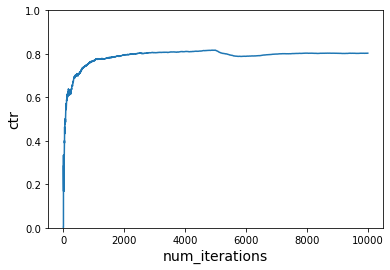

In [29]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

gammas = {
    get_noisy_cost: 0,
    get_noisy_cost_new1: 0 
}

num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(gammas)

ctr = run_simulation_multiple_noisy_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=False)

plot_ctr(total_iterations, ctr)

### Without learning

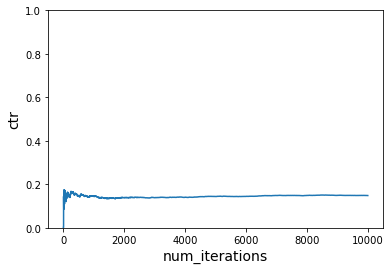

In [30]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

gammas = {
    get_noisy_cost: 0,
    get_noisy_cost_new1: 0 
}

num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(gammas)

ctr = run_simulation_multiple_noisy_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=False, do_learn=False)
plot_ctr(total_iterations, ctr)

Based on the above results, we were successful in replicating Scenerio Two.

## Numerical experiments

In this section, we will run a few numerical experiments to identify how the CTR curves change by varying the parameters defined above.

Some important notes:

- We make the assumption that $\gamma_{\text{new1}} = \gamma_{\text{cost}}$ for all experiments. Let's define this parameter $\gamma$.

- When `noisy` flag is set to `True`, the experiment runs through `num_experiments` experiments and averages all values of CTR with respect to experiment iteration to capture the overall effects of adding noise, without being too dependent on the choice of random seed value.

- We will only study the impacts of the CTR curves only when `do_learn = True`.

Additionally, we will fix our analysis by pre-defining the default generic values for all hyperparameters used in our experiments:

| Hyperparameter | Python Variable | Default Value |
| --- | --- | --- |
| discount rate, $\gamma$ | `gamma` | `0` |
| number of experiments | `num_experiments` | `10` |
| number of iterations per experiment | `num_iterations_per_cost_func` | `5000` |
| time-sensitive Gaussian noise, $\epsilon_t$ | `noisy` | `False` |

and for our model-specific hyperparameters (chosen by the exploration algorithms wiki page):

| Hyperparameter | Default Value |
| --- | --- |
| epsilon-greedy, $\epsilon$ | `0.2` |
| epsilon-first, $\tau$ | `2` |
| bagging-explorer, $n$ | `5` |
| softmax-explorer, $\lambda$ | `10` |
| RND-explorer, $(n, \epsilon)$ | `(3, 0.025)` |

We will now define a generic `run_simulation` function aimed to run our experiments using the specified parameters in the calling of the function:

In [31]:
from statistics import mean

def run_simulation(algorithm, gamma = 0, parameter = None, num_experiments = 10, 
                   num_iterations_per_cost_func = 5000, noisy = False, do_learn = True):
    
    config = {
        'epsilon_greedy': '--epsilon {}'.format(parameter if parameter else 0.2),
        'epsilon_first': "--first {}".format(parameter if parameter else 2),
        'bagging_explorer': "--bag {}".format(parameter if parameter else 5),
        'softmax_explorer': "--softmax --lambda {}".format(parameter if parameter else 10),
        'rnd_explorer': "--rnd {} --epsilon {}".format(*parameter if parameter else (3, 0.025))
    }

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    vw = pyvw.vw("--cb_explore_adf -q UA --quiet {}".format(config[algorithm]))


    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr_list = []
    for iterate in range(1, num_experiments + 1):
        random.seed(iterate)

        ctr = run_simulation_multiple_noisy_cost_functions(vw,
            num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

        ctr_list.append(ctr)

        if not noisy:
            break

    ctr_list = list(map(mean, zip(*ctr_list)))
    print('Gamma: {}, Parameter: {}; CTR: {} '.format(gamma, 'default' if parameter is None else parameter, ctr_list[-1]))
    plot_ctr(total_iterations, ctr)

## Discount Rate Analysis

We begin our analysis by varying discount rate $\gamma$. Recall that when $\gamma = 1$, the cost constants reflect no bias for all time steps $t$. When $\gamma = 0$, the cost constants degenerate to Scenerio 2 where the cost constants are not defined with respect to time. The choices of $\gamma$ used for our analysis is detailed as follows:

| Algorithm | $\gamma$ hyperparameter space |
| --- | --- |
| epsilon-greedy | `[0, 0.99, 0.999, 0.9999]` |
| epsilon-first | `[0, 0.5, 0.7, 0.9]` |
| bagging-explorer | `[0, 0.5, 0.7, 0.9]` |
| softmax-explorer | `[0, 0.25, 0.75, 0.9]` |
| RND-explorer | `[0, 0.25, 0.75, 0.9]` |

For each algorithm, we run the overall simulation under the default 10000 iterations and the elongated 50000 iterations to study the long-term effects of varying discount rate.

### Epsilon-greedy:

Gamma: 0, Parameter: default; CTR: 0.8023952095807554 
Gamma: 0.99, Parameter: default; CTR: 0.7972950046393604 
Gamma: 0.999, Parameter: default; CTR: 0.7591867867647594 
Gamma: 0.9999, Parameter: default; CTR: 0.6031829364012434 


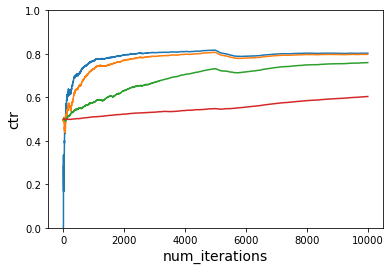

In [32]:
for gamma in [0, 0.99, 0.999, 0.9999]:
    run_simulation('epsilon_greedy', gamma = gamma, noisy = False)

Gamma: 0, Parameter: default; CTR: 0.8233932135734491 
Gamma: 0.99, Parameter: default; CTR: 0.8225328532238916 
Gamma: 0.999, Parameter: default; CTR: 0.814234279804638 
Gamma: 0.9999, Parameter: default; CTR: 0.7516962175223825 


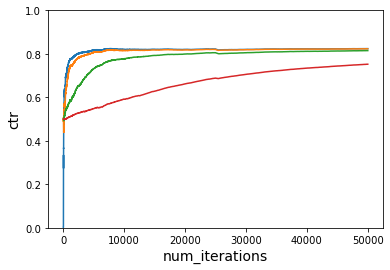

In [33]:
for gamma in [0, 0.99, 0.999, 0.9999]:
    run_simulation('epsilon_greedy', gamma = gamma, noisy = False, num_iterations_per_cost_func = 25000)

As $\gamma \rightarrow 1$, we observe that the CTR curves converge to the horizontal line defined by $CTR = 0.5$. As we increase the number of iterations, we additionally observe that for all $\gamma < 1$, $CTR \rightarrow \approx 0.8$. It's also important to note that when the cost functions change from `get_noisy_cost` to `get_noisy_cost_new1`, the CTR values are more resiliant to this change in preferences.

### Epsilon-first:

Gamma: 0, Parameter: default; CTR: 0.5591816367265385 
Gamma: 0.5, Parameter: default; CTR: 0.8151070204440729 
Gamma: 0.7, Parameter: default; CTR: 0.8676386294417634 
Gamma: 0.9, Parameter: default; CTR: 0.5063005939755207 


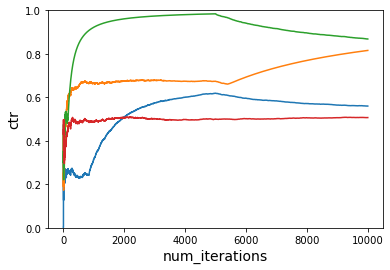

In [34]:
for gamma in [0, 0.5, 0.7, 0.9]:
    run_simulation('epsilon_first', gamma = gamma, noisy = False)

Gamma: 0, Parameter: default; CTR: 0.5910379241516852 
Gamma: 0.5, Parameter: default; CTR: 0.8250772923131457 
Gamma: 0.7, Parameter: default; CTR: 0.8716315183041683 
Gamma: 0.9, Parameter: default; CTR: 0.5008609171982947 


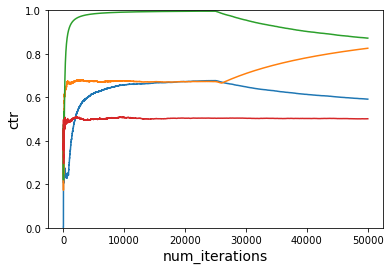

In [35]:
for gamma in [0, 0.5, 0.7, 0.9]:
    run_simulation('epsilon_first', gamma = gamma, noisy = False, num_iterations_per_cost_func = 25000)

Although less obvious than the epsilon-greedy case, we observe that the CTR curves similarly converge to the horizontal line defined by $CTR = 0.5$ as $\gamma \rightarrow 1$. Increasing the number of iterations seemed to indicate no converging behavior when varying $\gamma$. This might be attributed to how CTR values are more prone to variation when preferences are changed (when the cost functions change from `get_noisy_cost` to `get_noisy_cost_new1`).

### Bagging-explorer:

Gamma: 0, Parameter: default; CTR: 0.8561876247504024 
Gamma: 0.9, Parameter: default; CTR: 0.8464044215521439 
Gamma: 0.99, Parameter: default; CTR: 0.841860311641044 
Gamma: 0.999, Parameter: default; CTR: 0.8008393697273308 
Gamma: 0.9999, Parameter: default; CTR: 0.5422154835582986 


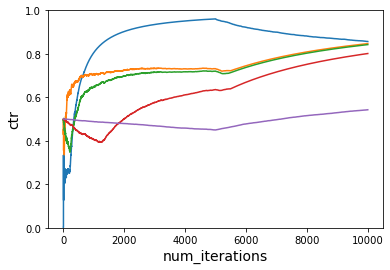

In [36]:
for gamma in [0, 0.9, 0.99, 0.999, 0.9999]:
    run_simulation('bagging_explorer', gamma = gamma, noisy = False)

Similarly to both epsilon-greedy and epsilon-first, we observe that the CTR curves converge to the horizontal line defined by $CTR = 0.5$ as $\gamma \rightarrow 1$.

Gamma: 0, Parameter: default; CTR: 0.8561876247504024 
Gamma: 0.5, Parameter: default; CTR: 0.9785800743085398 
Gamma: 0.7, Parameter: default; CTR: 0.9818045328336134 
Gamma: 0.9, Parameter: default; CTR: 0.8464044215521439 


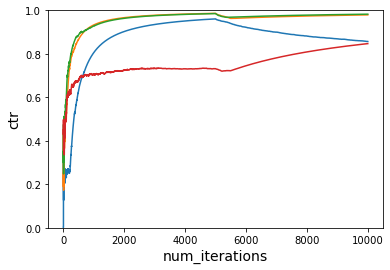

In [37]:
for gamma in [0, 0.5, 0.7, 0.9]:
    run_simulation('bagging_explorer', gamma = gamma, noisy = False)

Gamma: 0, Parameter: default; CTR: 0.9910179640728753 
Gamma: 0.5, Parameter: default; CTR: 0.9958357753418088 
Gamma: 0.7, Parameter: default; CTR: 0.995961704970976 
Gamma: 0.9, Parameter: default; CTR: 0.8607379701395922 


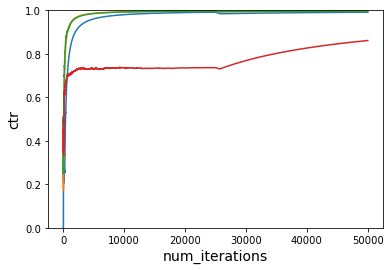

In [38]:
for gamma in [0, 0.5, 0.7, 0.9]:
    run_simulation('bagging_explorer', gamma = gamma, noisy = False, num_iterations_per_cost_func = 25000)

When we increase the number of iterations, the bagging explorer seemed to significantly increase the performance of CTR. This showcases the power of ensemble methods (one which bagging explorer use) when sufficiently large number of iterations is given in the simulation.

### Softmax-explorer:

Gamma: 0, Parameter: default; CTR: 0.8519960079839378 
Gamma: 0.99, Parameter: default; CTR: 0.8482609277215623 
Gamma: 0.999, Parameter: default; CTR: 0.7911856387611091 
Gamma: 0.9999, Parameter: default; CTR: 0.6197444233171134 
Gamma: 0.99999, Parameter: default; CTR: 0.48876527009897835 


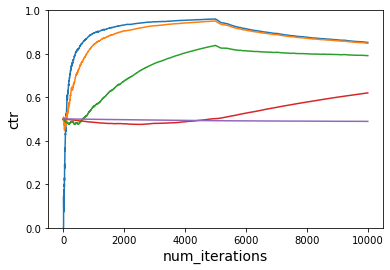

In [39]:
for gamma in [0, 0.99, 0.999, 0.9999, 0.99999]:
    run_simulation('softmax_explorer', gamma = gamma, noisy = False)

Again, we observe that the CTR curves converge to the horizontal line defined by $CTR = 0.5$ as $\gamma \rightarrow 1$. The converging pattern of softmax-explorer is noticeable in a smaller hyperparameter interval than the other algorithms. This indicates how resiliant model performance is when discount rate is changed.

Gamma: 0, Parameter: default; CTR: 0.8519960079839378 
Gamma: 0.25, Parameter: default; CTR: 0.845325519716497 
Gamma: 0.75, Parameter: default; CTR: 0.8529472649932517 
Gamma: 0.9, Parameter: default; CTR: 0.8471290437563844 


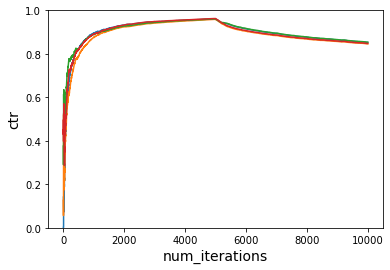

In [40]:
for gamma in [0, 0.25, 0.75, 0.9]:
    run_simulation('softmax_explorer', gamma = gamma, noisy = False)

Gamma: 0, Parameter: default; CTR: 0.8625748503000067 
Gamma: 0.25, Parameter: default; CTR: 0.9245142057405328 
Gamma: 0.75, Parameter: default; CTR: 0.9366972374306538 
Gamma: 0.9, Parameter: default; CTR: 0.9577092418859433 


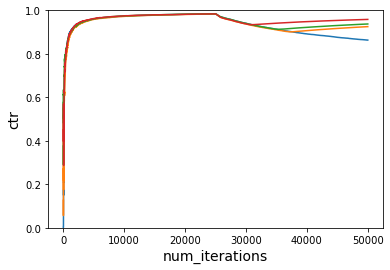

In [41]:
for gamma in [0, 0.25, 0.75, 0.9]:
    run_simulation('softmax_explorer', gamma = gamma, noisy = False, num_iterations_per_cost_func = 25000)

Increasing the number of iterations didn't drastically change the successful learning of the user's initial preferences, but once preferences are changed, more iterations show that the CTR values branch out for varying choices of $\gamma$. There isn't much significant difference with these changes due to how softmax-explorer properly controls uncertainty in exploration.

### RND-explorer:

Gamma: 0, Parameter: default; CTR: 0.9356287425148428 
Gamma: 0.99, Parameter: default; CTR: 0.9297406039952324 
Gamma: 0.999, Parameter: default; CTR: 0.8991917763920303 
Gamma: 0.9999, Parameter: default; CTR: 0.6482080248579376 
Gamma: 0.99999, Parameter: default; CTR: 0.5012265457055856 


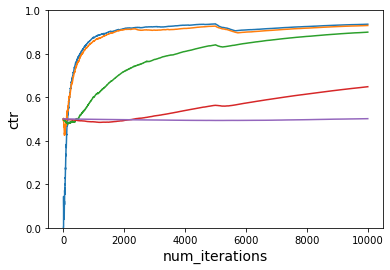

In [42]:
for gamma in [0, 0.99, 0.999, 0.9999, 0.99999]:
    run_simulation('rnd_explorer', gamma = gamma, noisy = False)

We observe that the CTR curves converge to the horizontal line defined by $CTR = 0.5$ as $\gamma \rightarrow 1$. The converging pattern of RND-explorer behaves similarly to softmax-explorer.

Gamma: 0, Parameter: default; CTR: 0.9356287425148428 
Gamma: 0.25, Parameter: default; CTR: 0.9059048508613124 
Gamma: 0.75, Parameter: default; CTR: 0.9216364363828506 
Gamma: 0.9, Parameter: default; CTR: 0.9328651888841829 


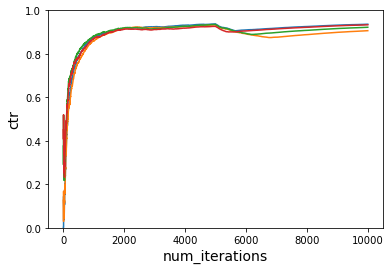

In [43]:
for gamma in [0, 0.25, 0.75, 0.9]:
    run_simulation('rnd_explorer', gamma = gamma, noisy = False)

Gamma: 0, Parameter: default; CTR: 0.9546307385238877 
Gamma: 0.25, Parameter: default; CTR: 0.9437957406322653 
Gamma: 0.75, Parameter: default; CTR: 0.9298362693133735 
Gamma: 0.9, Parameter: default; CTR: 0.9435989858815566 


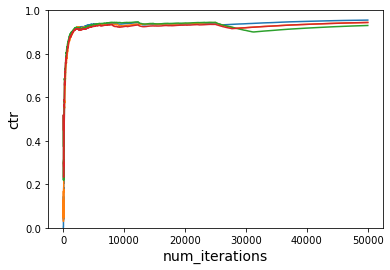

In [44]:
for gamma in [0, 0.25, 0.75, 0.9]:
    run_simulation('rnd_explorer', gamma = gamma, noisy = False, num_iterations_per_cost_func = 25000)

Similar to softmax-explorer, increasing the number of iterations didn't drastically change the successful learning of the user's initial preferences. Once preferences are changed, more iterations show that the CTR values branch out for varying choices of $\gamma$. There isn't much significant difference with these changes due to how RND-explorer properly stabilizes the above behavior by passing in very minimal exploration via hyperparameter $\epsilon$.

## Noise Analysis

From the previous analysis, we choose the best choice of $\gamma$ and proceed our experimentation by studying how adding Gaussian noise to the signal change the overall performance of the algorithm. Specifically, we plot the simulation results with unnoisy rewards with the results with noisy rewards to study how the CTR curves compare.

We set `num_experiments = 10` to reduce variation of noise with respect to seed values. Higher values for `num_experiments` would yield a convergent signal that represents the expected simulation for noisy rewards, but inflating this hyperparameter value can be computationally expensive.

### Epsilon-greedy

Gamma: 0, Parameter: default; CTR: 0.8023952095807554 
Gamma: 0, Parameter: default; CTR: 0.7536028078702488 


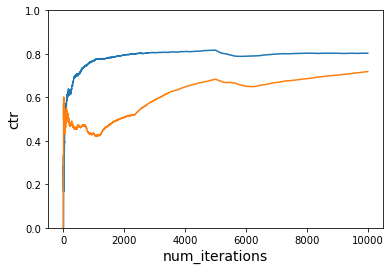

In [45]:
run_simulation('epsilon_greedy', gamma = 0, noisy = False)
run_simulation('epsilon_greedy', gamma = 0, noisy = True)

### Epsilon-first

Gamma: 0.7, Parameter: default; CTR: 0.8676386294417634 
Gamma: 0.7, Parameter: default; CTR: 0.6252017561236057 


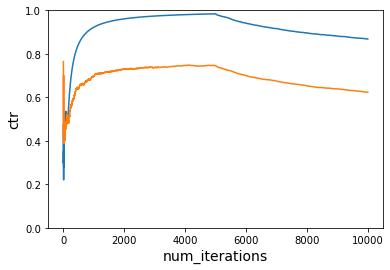

In [46]:
run_simulation('epsilon_first', gamma = 0.7, noisy = False)
run_simulation('epsilon_first', gamma = 0.7, noisy = True)

### Bagging-explorer

Gamma: 0.7, Parameter: default; CTR: 0.9818045328336134 
Gamma: 0.7, Parameter: default; CTR: 0.8763380570219008 


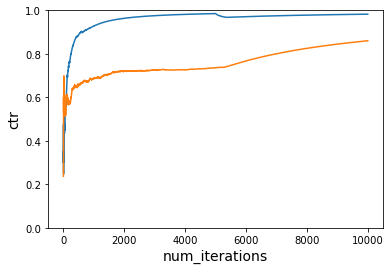

In [47]:
run_simulation('bagging_explorer', gamma = 0.7, noisy = False)
run_simulation('bagging_explorer', gamma = 0.7, noisy = True)

### Softmax-explorer

Gamma: 0.75, Parameter: default; CTR: 0.8529472649932517 
Gamma: 0.75, Parameter: default; CTR: 0.8240636307901038 


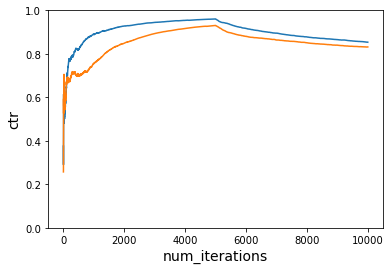

In [48]:
run_simulation('softmax_explorer', gamma = 0.75, noisy = False)
run_simulation('softmax_explorer', gamma = 0.75, noisy = True)

### RND-explorer

Gamma: 0, Parameter: default; CTR: 0.9356287425148428 
Gamma: 0, Parameter: default; CTR: 0.8415169695264888 


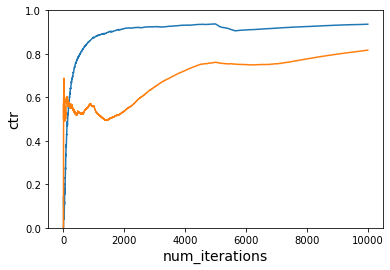

In [49]:
run_simulation('rnd_explorer', gamma = 0, noisy = False)
run_simulation('rnd_explorer', gamma = 0, noisy = True)

From the plots above, we observe that for all exploration algorithms, adding noise to the rewards distribution decreases the overall CTR. Additionally, the noise appears to significantly affect CTR to the extent of being unable to recover the results of Scenerio Two by adding iterations to the experiment.

## Final Results of Simulations

Because the experiments are primarily aimed to study the impacts of discount factor and noise in these exploration models, *we will not individually tune the parameters required for each algorithm in this write-up*. Shown below are the final results of the numerical experiments implemented in this writeup:

| Algorithm | Gamma | Without noise | With noise |
| --- | --- | --- | --- |
| Epsilon-greedy | `0` | `0.8023952095807554`  | `0.7168795885865196` |
| Epsilon-first | `0.7` | `0.8676386294417634` | `0.6252017561236057` |
| **Bagging-explorer** | `0.7` | `0.9818045328336134` | `0.8763380570219008` |
| Softmax-explorer | `0.75` | `0.8529472649932517` | `0.8240636307901038` |
| RND-explorer | `0` | `0.9356287425148428` | `0.8415169695264888`  |

The best performing model is the bagging-exploration algorithm for noisy rewards. This is expected due to how consistently well ensemble methods generically capture the important features of noisy rewards.


## Conclusion

In this write-up, we were successful in generalizing Scenerio Two to account for time-sensitivity in our rewards distribution using discounting in reinforcement learning. We were also successful in adding time-sensitive Gaussian noise to our model to reflect irrationality of user behavior. Using these generalized exploration models, we study the effects of tuning these two hyperparameters across the entire Vowpal Wabbit's suite of contextual bandits algorithms and performed a brief analysis detailing our findings after successful tuning.

## Acknowledgements

I would like to thank Microsoft Research's RL Team for providing me the opportunity to possibly contribute to Vowpal Wabbit's open-source development this summer and further developing my interest and enriching my experiences in reinforcement learning.